<a href="https://colab.research.google.com/github/Lursen/Time-series-prediction/blob/main/Time_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Класс однослойной сети прямого распространения

In [ ]:
import torch 
import matplotlib.pyplot as plt
import numpy as np

class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            self.tanh = torch.nn.Tanh()

        def forward(self, x):
            hidden = self.fc1(x)
            tanh   = self.tanh(hidden)
            output = self.fc2(tanh)
            output = self.tanh(output)
            return output

Работа с данными

In [ ]:
import pandas as pd
data= pd.read_csv("Прошлые данные - EUR_USD.csv", decimal=",")

data['Дата'] =pd.to_datetime(data.Дата)
data.sort_values(by='Дата', inplace=True, ascending=True)
data = data.reset_index(drop=True)
data

,Дата,Цена,Откр.,Макс.,Мин.,Изм. %
0,2020-01-10,1.1747,1.1719,1.1770,1.1717,"0,25%"
1,2020-01-12,1.2070,1.1928,1.2077,1.1926,"1,19%"
2,2020-02-10,1.1713,1.1748,1.1751,1.1695,"-0,29%"
3,2020-02-11,1.1640,1.1658,1.1658,1.1622,"-0,06%"
4,2020-02-12,1.2115,1.2070,1.2119,1.2040,"0,37%"
...,...,...,...,...,...,...
257,2021-12-03,1.1952,1.1983,1.1990,1.1910,"-0,27%"
258,2021-12-04,1.1909,1.1891,1.1920,1.1870,"0,11%"
259,2021-12-05,1.2069,1.2148,1.2153,1.2065,"-0,63%"
260,2021-12-07,1.1859,1.1872,1.1881,1.1836,"-0,12%"


In [ ]:
price = data['Цена']
price 

0      1.1747
1      1.2070
2      1.1713
3      1.1640
4      1.2115
        ...  
257    1.1952
258    1.1909
259    1.2069
260    1.1859
261    1.1727
Name: Цена, Length: 262, dtype: float64

In [ ]:
# normalization
max_price = price.to_numpy().max()
norm_price = price/max_price
norm_price

0      0.953103
1      0.979310
2      0.950345
3      0.944422
4      0.982961
         ...   
257    0.969736
258    0.966247
259    0.979229
260    0.962191
261    0.951481
Name: Цена, Length: 262, dtype: float64

In [ ]:
import math
train = norm_price[0:math.floor(0.8 * len(norm_price.index))]
test = norm_price[math.floor(0.8 * len(norm_price.index)):len(norm_price.index)]

train = train.values
test = test.values

Разность значений

In [ ]:
import pandas as pd
data= pd.read_csv("Прошлые данные - EUR_USD (1).csv", decimal=",")
data['Дата'] =pd.to_datetime(data.Дата)
data.sort_values(by='Дата', inplace=True, ascending=True)
data = data.reset_index(drop=True)
price = data['Цена']

import math
train = price[0:math.floor(0.8 * len(price.index))]
test = price[math.floor(0.8 * len(price.index)):len(price.index)]

train = train.values
test = test.values

for i in range(0,len(train)-1):
  train[i] = train[i+1]-train[i]

for i in range(0,len(test)-1):
  test[i] = test[i+1]-test[i]

train = np.delete(train,-1)
test = np.delete(test,-1)

Обучение сети

In [ ]:
t = 10
model = Feedforward(t, 20)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

# training
model.train()
model.double()
epoch = 1000
for epoch in range(epoch):
    rnd = np.random.randint(0,np.shape(train)[0] - (t+1))
    xs = torch.from_numpy(train[rnd:rnd+t])
    ys = torch.tensor(train[rnd+t])

    optimizer.zero_grad()
    # Forward pass
    y_pred = model(xs)
    # Compute Loss
    loss = criterion(y_pred.squeeze(), ys)
   
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()),'y_orig:', ys.item(), 'y_pred:', y_pred.item())
    
    # Backward pass
    loss.backward()
    optimizer.step()

Тестирование

In [ ]:
# evaluation
model.eval()
error = []
accuracy=[]
y_f = []
y_p = []
for epoch in range(0,len(test)-t):
  xs = torch.from_numpy(test[epoch:epoch+t])
  ys = torch.tensor(test[epoch+t])
  y_pred = model(xs)
  loss = criterion(y_pred.squeeze(), ys)
  
  accuracy.append(1-np.abs(y_pred.item() - ys.item()))
  error.append(loss.item())
  y_f.append(ys.item())
  y_p.append(y_pred.item())
print('Accuracy:', np.mean(accuracy), 'STD', np.std(error))

Accuracy: 0.9856097008784178 STD 0.0006493381380509784


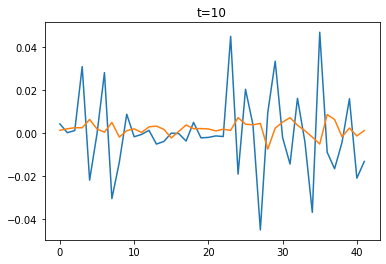

In [ ]:
plt.plot(y_f)
plt.plot(y_p)
plt.title("t=10" )
plt.show()